# U-Net Model

In [ ]:
import os
import cv2
import time
import random
import numpy as np
from glob import glob
from tqdm import tqdm
from operator import add
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

In [ ]:
# -------------------------
# Dataset
# -------------------------
class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):
        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image.astype(np.float32))

        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask/255.0, axis=0)
        mask = torch.from_numpy(mask.astype(np.float32))

        return image, mask

    def __len__(self):
        return self.n_samples


In [ ]:
# -------------------------
# U-Net Blocks
# -------------------------
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        s = self.conv(x)
        p = self.pool(s)
        return s, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, 2, stride=2)
        self.conv = conv_block(out_c*2, out_c)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.e1 = encoder_block(3,64)
        self.e2 = encoder_block(64,128)
        self.e3 = encoder_block(128,256)
        self.e4 = encoder_block(256,512)
        self.b = conv_block(512,1024)
        self.d1 = decoder_block(1024,512)
        self.d2 = decoder_block(512,256)
        self.d3 = decoder_block(256,128)
        self.d4 = decoder_block(128,64)
        self.outputs = nn.Conv2d(64,1,1)

    def forward(self, x):
        s1,p1 = self.e1(x)
        s2,p2 = self.e2(p1)
        s3,p3 = self.e3(p2)
        s4,p4 = self.e4(p3)
        b = self.b(p4)
        d1 = self.d1(b,s4)
        d2 = self.d2(d1,s3)
        d3 = self.d3(d2,s2)
        d4 = self.d4(d3,s1)
        return self.outputs(d4)

In [ ]:
# -------------------------
# Loss Functions
# -------------------------
class DiceBCELoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        return BCE + dice_loss

In [ ]:
# -------------------------
# Utilities
# -------------------------
def seeding(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def epoch_time(start_time,end_time):
    elapsed_time = end_time - start_time
    return int(elapsed_time/60), int(elapsed_time%60)

def calculate_metrics(y_true, y_pred):
    y_true = y_true.cpu().numpy().reshape(-1)>0.5
    y_pred = (torch.sigmoid(y_pred).cpu().numpy().reshape(-1)>0.5)
    return [
        jaccard_score(y_true,y_pred),
        f1_score(y_true,y_pred),
        recall_score(y_true,y_pred),
        precision_score(y_true,y_pred),
        accuracy_score(y_true,y_pred)
    ]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)
    mask = np.concatenate([mask,mask,mask], axis=-1)
    return mask

In [ ]:
# -------------------------
# Image Enhancement Pipeline
# -------------------------
def enhance_image(image):
    """Apply green channel, CLAHE, Gamma correction"""
    results = {}

    # Green channel extraction
    green = image[:,:,1]
    results['green'] = green

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(8,8))
    clahe_img = clahe.apply(green)
    results['clahe'] = clahe_img

    # Gamma correction
    gamma = 1.2
    gamma_img = np.array(255*(clahe_img/255)**gamma, dtype=np.uint8)
    results['gamma'] = gamma_img

    return results

In [ ]:
# -------------------------
# Mount Google Drive
# -------------------------
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/KaggleRetina"
train_x = sorted(glob(f"{base_dir}/train/image/*"))
train_y = sorted(glob(f"{base_dir}/train/mask/*"))
valid_x = sorted(glob(f"{base_dir}/test/image/*"))
valid_y = sorted(glob(f"{base_dir}/test/mask/*"))

# Result directories
results_dir = f"{base_dir}/results"
intermediate_dir = f"{results_dir}/intermediate"
final_dir = f"{results_dir}/final"
for d in [results_dir, intermediate_dir, final_dir]:
    create_dir(d)

checkpoint_path = f"{base_dir}/files/checkpoint.pth"


Mounted at /content/drive


In [ ]:
# -------------------------
# Hyperparameters
# -------------------------
H = W = 512
size = (H,W)
batch_size = 2
lr = 1e-4
num_epochs = 50

In [ ]:
# -------------------------
# Data Loaders
# -------------------------
train_dataset = DriveDataset(train_x,train_y)
valid_dataset = DriveDataset(valid_x,valid_y)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size,shuffle=False,num_workers=2)

In [ ]:
# -------------------------
# Model, Loss, Optimizer
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = build_unet().to(device)
loss_fn = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)


Using device: cuda


In [ ]:
# -------------------------
# Training Loop
# -------------------------
best_valid_loss = float("inf")
seeding(42)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for x,y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = loss_fn(pred,y)
            valid_loss += loss.item()
    valid_loss /= len(valid_loader)

    if valid_loss < best_valid_loss:
        print(f"Validation loss improved {best_valid_loss:.4f} -> {valid_loss:.4f}. Saving model.")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    scheduler.step(valid_loss)
    epoch_mins, epoch_secs = epoch_time(start_time, time.time())
    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_mins}m {epoch_secs}s | Train Loss: {train_loss:.4f} | Val Loss: {valid_loss:.4f}")


Validation loss improved inf -> 1.3106. Saving model.
Epoch 1/50 | Time: 0m 27s | Train Loss: 1.2449 | Val Loss: 1.3106
Validation loss improved 1.3106 -> 1.0154. Saving model.
Epoch 2/50 | Time: 0m 29s | Train Loss: 1.0457 | Val Loss: 1.0154
Validation loss improved 1.0154 -> 0.9713. Saving model.
Epoch 3/50 | Time: 0m 27s | Train Loss: 0.9845 | Val Loss: 0.9713
Validation loss improved 0.9713 -> 0.9199. Saving model.
Epoch 4/50 | Time: 0m 28s | Train Loss: 0.9377 | Val Loss: 0.9199
Validation loss improved 0.9199 -> 0.8829. Saving model.
Epoch 5/50 | Time: 0m 29s | Train Loss: 0.8956 | Val Loss: 0.8829
Validation loss improved 0.8829 -> 0.8484. Saving model.
Epoch 6/50 | Time: 0m 29s | Train Loss: 0.8567 | Val Loss: 0.8484
Validation loss improved 0.8484 -> 0.8004. Saving model.
Epoch 7/50 | Time: 0m 28s | Train Loss: 0.8183 | Val Loss: 0.8004
Validation loss improved 0.8004 -> 0.7629. Saving model.
Epoch 8/50 | Time: 0m 28s | Train Loss: 0.7805 | Val Loss: 0.7629
Validation loss imp

In [ ]:
# =========================
# Evaluation & Results
# =========================
model.load_state_dict(torch.load(checkpoint_path,map_location=device))
model.eval()

metrics_score = [0.0]*5
time_taken = []

test_x = sorted(glob(f"{base_dir}/test/image/*"))
test_y = sorted(glob(f"{base_dir}/test/mask/*"))

for i,(x_path,y_path) in enumerate(tqdm(zip(test_x,test_y), total=len(test_x))):
    name = os.path.splitext(os.path.basename(x_path))[0]
    image = cv2.imread(x_path)
    # -----------------
    # Enhancement
    # -----------------
    enhanced_imgs = enhance_image(image)
    for k,img_enh in enhanced_imgs.items():
        create_dir(f"{intermediate_dir}/{k}")
        cv2.imwrite(f"{intermediate_dir}/{k}/{name}.png", img_enh)

    # Convert to 3 channel for model
    img_input = cv2.cvtColor(enhanced_imgs['gamma'], cv2.COLOR_GRAY2RGB)
    x_tensor = torch.from_numpy(np.transpose(img_input/255.0,(2,0,1))).unsqueeze(0).float().to(device)

    mask = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
    y_tensor = torch.from_numpy(mask[np.newaxis,np.newaxis,:,:]/255.0).float().to(device)

    start = time.time()
    with torch.no_grad():
        pred = model(x_tensor)
    time_taken.append(time.time()-start)

    # Post-processing
    pred_mask = (torch.sigmoid(pred)[0,0].cpu().numpy()>0.5).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel)

    # Save final results
    ori_mask_color = mask_parse(mask)
    pred_mask_color = mask_parse(pred_mask)
    line = np.ones((H,10,3),dtype=np.uint8)*128
    cat_img = np.concatenate([image,line,ori_mask_color,line,pred_mask_color*255],axis=1)
    cv2.imwrite(f"{final_dir}/{name}.png", cat_img)

    metrics_score = list(map(add, metrics_score, calculate_metrics(y_tensor,pred)))


100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


{'Jaccard': np.float64(0.5545873424785647), 'F1': 0.7117779201330059, 'Recall': 0.6709164140144114, 'Precision': 0.76684780217632, 'Accuracy': 0.953254508972168}
Average FPS: 79.42


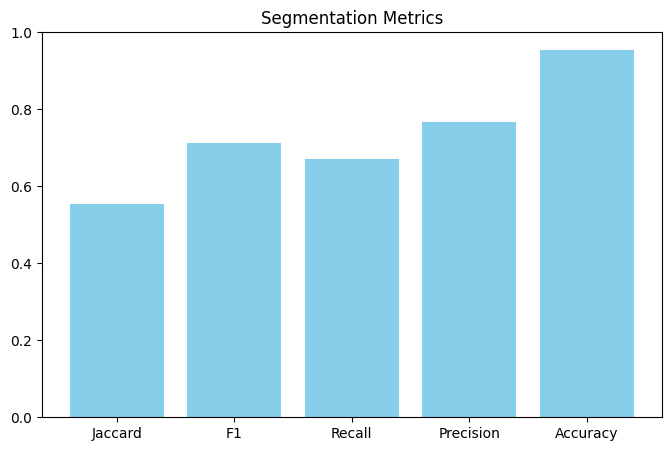

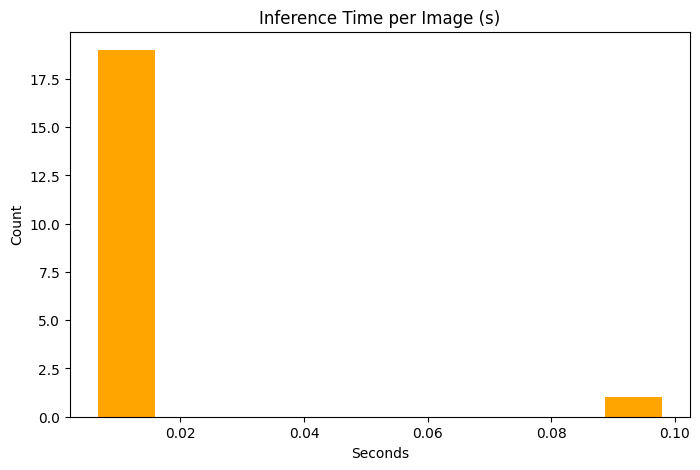

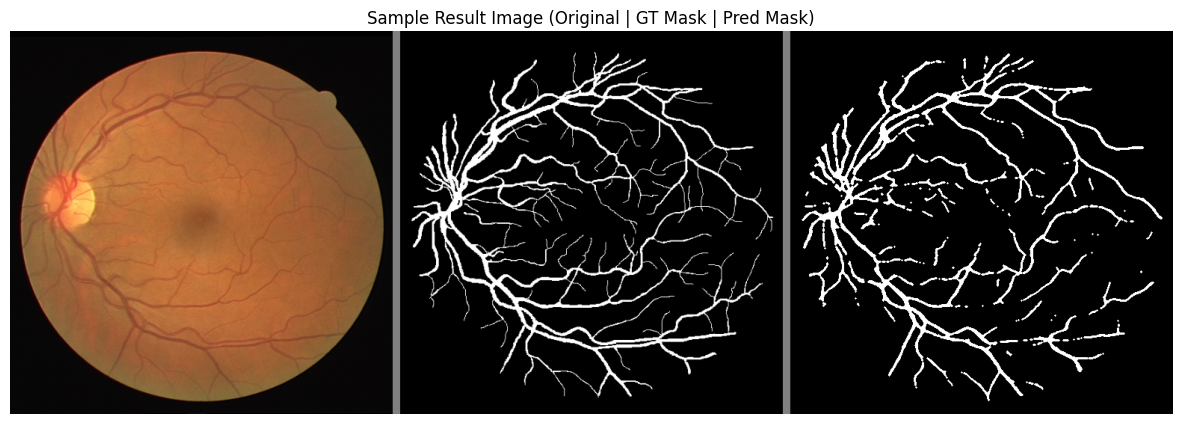

In [ ]:
# =========================
# Metrics & Graphs
# =========================
num_images = len(test_x)
metrics_avg = [s/num_images for s in metrics_score]
metrics_names = ["Jaccard","F1","Recall","Precision","Accuracy"]
fps = 1/np.mean(time_taken)

print({k:v for k,v in zip(metrics_names, metrics_avg)})
print(f"Average FPS: {fps:.2f}")

# Bar chart for metrics
plt.figure(figsize=(8,5))
plt.bar(metrics_names, metrics_avg, color='skyblue')
plt.ylim(0,1)
plt.title("Segmentation Metrics")
plt.show()

# Inference time histogram
plt.figure(figsize=(8,5))
plt.hist(time_taken, bins=10, color='orange')
plt.title("Inference Time per Image (s)")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

# Sample visualization
sample_idx = 0
sample_name = os.path.splitext(os.path.basename(test_x[sample_idx]))[0]
sample_final = cv2.imread(f"{final_dir}/{sample_name}.png")
plt.figure(figsize=(15,5))
plt.imshow(cv2.cvtColor(sample_final,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Sample Result Image (Original | GT Mask | Pred Mask)")
plt.show()

In [ ]:
import albumentations as A

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)
        self.transform = transform

    def __getitem__(self, index):
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        image = image/255.0
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image.astype(np.float32))

        mask = np.expand_dims(mask/255.0, axis=0)
        mask = torch.from_numpy(mask.astype(np.float32))

        return image, mask

    def __len__(self):
        return self.n_samples


In [ ]:
# -------------------------
# Data Augmentation Transforms
# -------------------------
train_transform = A.Compose([
    A.Rotate(limit=45, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ColorJitter(p=0.5),
    A.RandomCrop(H, W, p=0.5),
    A.Resize(H, W)
])

valid_transform = A.Compose([
    A.Resize(H, W)
])

In [ ]:
# -------------------------
# Data Loaders with Augmentation
# -------------------------
train_dataset = DriveDataset(train_x, train_y, transform=train_transform)
valid_dataset = DriveDataset(valid_x, valid_y, transform=valid_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# -------------------------
# Hyperparameters
# -------------------------
H = W = 512
size = (H,W)
batch_size = 4 # Increased batch size
lr = 5e-5 # Reduced learning rate
num_epochs = 100 # Increased number of epochs

In [ ]:
# -------------------------
# Model and Loss Selection
# -------------------------
def get_model(architecture_name):
    if architecture_name == "unet":
        return build_unet()
    # Add other architectures here
    else:
        raise ValueError(f"Unknown model architecture: {architecture_name}")

def get_loss_fn(loss_name):
    if loss_name == "DiceBCELoss":
        return DiceBCELoss()
    # Add other loss functions here
    else:
        raise ValueError(f"Unknown loss function: {loss_name}")

In [ ]:
# -------------------------
# Model, Loss, Optimizer (using selection functions)
# -------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Select model and loss function
model_architecture = "unet" # Example: "unet"
loss_function_name = "DiceBCELoss" # Example: "DiceBCELoss"

model = get_model(model_architecture).to(device)
loss_fn = get_loss_fn(loss_function_name)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)

Using device: cuda


In [ ]:
# -------------------------
# Training Loop
# -------------------------
best_valid_loss = float("inf")
seeding(42)

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    train_loss = 0
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for x,y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = loss_fn(pred,y)
            valid_loss += loss.item()
    valid_loss /= len(valid_loader)

    if valid_loss < best_valid_loss:
        print(f"Validation loss improved {best_valid_loss:.4f} -> {valid_loss:.4f}. Saving model.")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    scheduler.step(valid_loss)
    epoch_mins, epoch_secs = epoch_time(start_time, time.time())
    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_mins}m {epoch_secs}s | Train Loss: {train_loss:.4f} | Val Loss: {valid_loss:.4f}")

Validation loss improved inf -> 1.3158. Saving model.
Epoch 1/100 | Time: 0m 27s | Train Loss: 1.3905 | Val Loss: 1.3158
Validation loss improved 1.3158 -> 1.0592. Saving model.
Epoch 2/100 | Time: 0m 28s | Train Loss: 1.2036 | Val Loss: 1.0592
Validation loss improved 1.0592 -> 1.0207. Saving model.
Epoch 3/100 | Time: 0m 27s | Train Loss: 1.0903 | Val Loss: 1.0207
Validation loss improved 1.0207 -> 1.0067. Saving model.
Epoch 4/100 | Time: 0m 28s | Train Loss: 1.0374 | Val Loss: 1.0067
Validation loss improved 1.0067 -> 0.9726. Saving model.
Epoch 5/100 | Time: 0m 28s | Train Loss: 1.0033 | Val Loss: 0.9726
Validation loss improved 0.9726 -> 0.9284. Saving model.
Epoch 6/100 | Time: 0m 28s | Train Loss: 0.9711 | Val Loss: 0.9284
Validation loss improved 0.9284 -> 0.9277. Saving model.
Epoch 7/100 | Time: 0m 29s | Train Loss: 0.9557 | Val Loss: 0.9277
Validation loss improved 0.9277 -> 0.8871. Saving model.
Epoch 8/100 | Time: 0m 28s | Train Loss: 0.9268 | Val Loss: 0.8871
Validation 

In [ ]:
# =========================
# Evaluation & Results
# =========================
model.load_state_dict(torch.load(checkpoint_path,map_location=device))
model.eval()

metrics_score = [0.0]*5
time_taken = []

test_x = sorted(glob(f"{base_dir}/test/image/*"))
test_y = sorted(glob(f"{base_dir}/test/mask/*"))

for i,(x_path,y_path) in enumerate(tqdm(zip(test_x,test_y), total=len(test_x))):
    name = os.path.splitext(os.path.basename(x_path))[0]
    image = cv2.imread(x_path)
    # -----------------
    # Enhancement
    # -----------------
    enhanced_imgs = enhance_image(image)
    for k,img_enh in enhanced_imgs.items():
        create_dir(f"{intermediate_dir}/{k}")
        cv2.imwrite(f"{intermediate_dir}/{k}/{name}.png", img_enh)

    # Convert to 3 channel for model
    img_input = cv2.cvtColor(enhanced_imgs['gamma'], cv2.COLOR_GRAY2RGB)
    x_tensor = torch.from_numpy(np.transpose(img_input/255.0,(2,0,1))).unsqueeze(0).float().to(device)

    mask = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
    y_tensor = torch.from_numpy(mask[np.newaxis,np.newaxis,:,:]/255.0).float().to(device)

    start = time.time()
    with torch.no_grad():
        pred = model(x_tensor)
    time_taken.append(time.time()-start)

    # Post-processing
    pred_mask = (torch.sigmoid(pred)[0,0].cpu().numpy()>0.5).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel)

    # Save final results
    ori_mask_color = mask_parse(mask)
    pred_mask_color = mask_parse(pred_mask)
    line = np.ones((H,10,3),dtype=np.uint8)*128
    cat_img = np.concatenate([image,line,ori_mask_color,line,pred_mask_color*255],axis=1)
    cv2.imwrite(f"{final_dir}/{name}.png", cat_img)

    metrics_score = list(map(add, metrics_score, calculate_metrics(y_tensor,pred)))

100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


{'Jaccard': np.float64(0.6287901796195381), 'F1': 0.7710103004730705, 'Recall': 0.7895953388440982, 'Precision': 0.7593012633759083, 'Accuracy': 0.959619140625}
Average FPS: 112.86


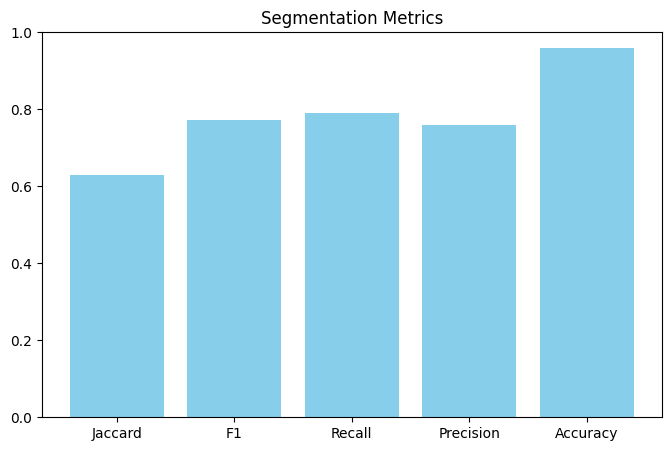

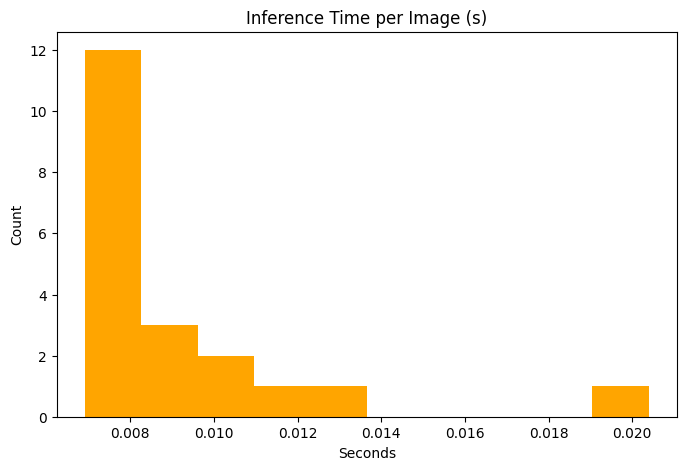

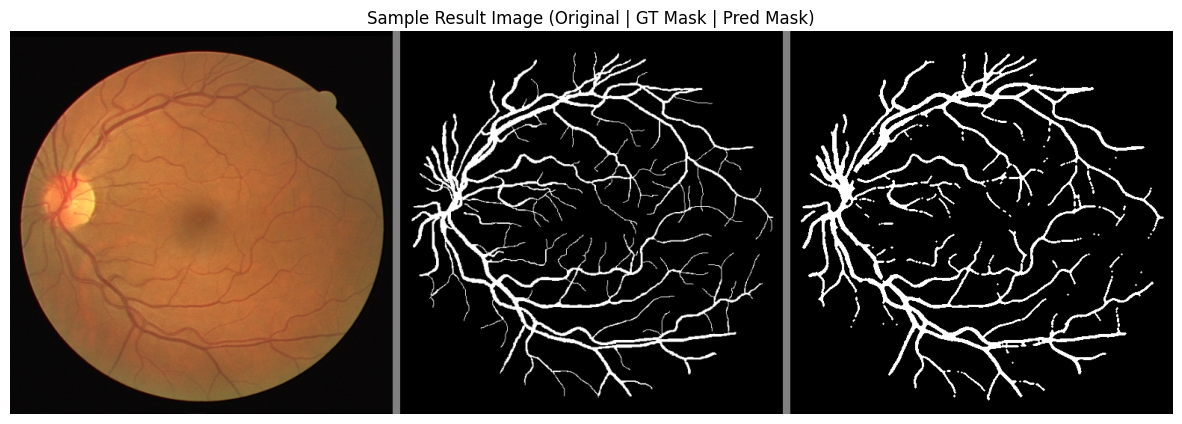

In [ ]:
# =========================
# Metrics & Graphs
# =========================
num_images = len(test_x)
metrics_avg = [s/num_images for s in metrics_score]
metrics_names = ["Jaccard","F1","Recall","Precision","Accuracy"]
fps = 1/np.mean(time_taken)

print({k:v for k,v in zip(metrics_names, metrics_avg)})
print(f"Average FPS: {fps:.2f}")

# Bar chart for metrics
plt.figure(figsize=(8,5))
plt.bar(metrics_names, metrics_avg, color='skyblue')
plt.ylim(0,1)
plt.title("Segmentation Metrics")
plt.show()

# Inference time histogram
plt.figure(figsize=(8,5))
plt.hist(time_taken, bins=10, color='orange')
plt.title("Inference Time per Image (s)")
plt.xlabel("Seconds")
plt.ylabel("Count")
plt.show()

# Sample visualization
sample_idx = 0
sample_name = os.path.splitext(os.path.basename(test_x[sample_idx]))[0]
sample_final = cv2.imread(f"{final_dir}/{sample_name}.png")
plt.figure(figsize=(15,5))
plt.imshow(cv2.cvtColor(sample_final,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Sample Result Image (Original | GT Mask | Pred Mask)")
plt.show()

# Neural Ode Unet

In [ ]:
!pip install torchdiffeq

In [12]:
import os
import shutil

# Unmount the drive if it's mounted
try:
    from google.colab import drive
    drive.flush_and_unmount()
except ValueError:
    pass # Drive was not mounted

# Remove contents of the mount point directory
mountpoint = '/content/drive'
if os.path.exists(mountpoint):
    for item in os.listdir(mountpoint):
        item_path = os.path.join(mountpoint, item)
        if os.path.isdir(item_path):
            shutil.rmtree(item_path)
        else:
            os.remove(item_path)

# Attempt to mount the drive again
drive.mount(mountpoint, force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [13]:
# =========================================
# Imports & reproducibility
# =========================================
import os
import glob
from pathlib import Path
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2


from torchdiffeq import odeint

# Basic reproducibility
def seed_everything(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(torch.cuda.device_count() > 0 and seed) # Corrected CUDA seed setting

seed_everything(42)


# =========================================
# Dataset with transforms, CLAHE & safe loading
# =========================================
class DriveDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_ext=('png',), mask_ext=('png',),
                 size=(256,256), use_green_channel=True, normalize=True, apply_clahe=False):
        self.img_paths = sorted([p for e in img_ext for p in glob.glob(os.path.join(img_dir, f'*.{e}'))])
        self.mask_paths = sorted([p for e in mask_ext for p in glob.glob(os.path.join(mask_dir, f'*.{e}'))])
        assert len(self.img_paths) > 0, f"No images found in {img_dir}"
        assert len(self.mask_paths) > 0, f"No masks found in {mask_dir}"

        # filter out unmatched files safely
        min_len = min(len(self.img_paths), len(self.mask_paths))
        if len(self.img_paths) != len(self.mask_paths):
            print(f"Warning: Image/Mask count mismatch. Using first {min_len} items.")
            self.img_paths = self.img_paths[:min_len]
            self.mask_paths = self.mask_paths[:min_len]


        self.size = size
        self.use_green_channel = use_green_channel
        self.normalize = normalize
        self.apply_clahe = apply_clahe

        # torch transforms for images (applied after we build single-channel tensor)
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(self.size)
        ])


    def __len__(self):
        return len(self.img_paths)


    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]

        try:
            img = Image.open(img_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')
        except Exception as e:
            print(f"Warning: Failed to load {img_path} or {mask_path}. Skipping. Error: {e}")
            # Return a dummy zero tensor to avoid crashing (will be ignored in training)
            return torch.zeros(1, *self.size), torch.zeros(1, *self.size)


        # convert to numpy for optional CLAHE and channel selection
        img_np = np.array(img).astype(np.float32) / 255.0 # HxWx3
        if self.use_green_channel:
            img_np = img_np[:, :, 1]
        else:
            # average channels
            img_np = img_np.mean(axis=2)


        # optional CLAHE (improves vessel contrast)
        if self.apply_clahe:
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            img_np = (clahe.apply((img_np*255).astype(np.uint8)).astype(np.float32))/255.0


        # resize using PIL for consistency
        img_pil = Image.fromarray((img_np*255).astype(np.uint8))
        # Use 'filter' instead of 'resample' for compatibility with older Pillow versions
        img_pil = img_pil.resize(self.size, resample=Image.BILINEAR)
        img_np = np.array(img_pil).astype(np.float32)/255.0


        mask = mask.resize(self.size, resample=Image.NEAREST)
        mask_np = (np.array(mask).astype(np.float32) / 255.0)
        mask_np = (mask_np > 0.5).astype(np.float32)


        # add channel dim
        img_tensor = torch.from_numpy(img_np).unsqueeze(0) # 1xHxW
        mask_tensor = torch.from_numpy(mask_np).unsqueeze(0)


        if self.normalize:
            img_tensor = (img_tensor - 0.5) / 0.5


        return img_tensor.float(), mask_tensor.float()


# =========================================
# Basic Conv & Residual blocks
# =========================================
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class ResidualConv(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = ConvBlock(ch, ch)
    def forward(self, x):
        return x + self.conv(x)


# =========================================
# ODE Function & Neural ODE Module
# =========================================
class ODEFunc(nn.Module):
    def __init__(self, channels, use_bn=True):
        super().__init__()
        layers = []
        if use_bn:
            layers += [nn.BatchNorm2d(channels)]
        layers += [nn.ReLU(inplace=True), nn.Conv2d(channels, channels, kernel_size=3, padding=1)]
        if use_bn:
            layers += [nn.BatchNorm2d(channels)]
        layers += [nn.ReLU(inplace=True), nn.Conv2d(channels, channels, kernel_size=3, padding=1)]
        self.net = nn.Sequential(*layers)

    def forward(self, t, x):
        return self.net(x)

class NeuralODE(nn.Module):
    def __init__(self, odefunc: nn.Module, tol=1e-3, method='rk4', residual=True):
        super().__init__()
        self.odefunc = odefunc
        self.register_buffer('integration_times', torch.tensor([0.0,1.0]))
        self.method = method
        self.tol = tol
        self.residual = residual

    def forward(self, x):
        tt = self.integration_times.type_as(x)
        out = odeint(self.odefunc, x, tt, rtol=self.tol, atol=self.tol, method=self.method)
        final = out[-1]
        if self.residual:
            return x + final
        return final


# =========================================
# ODE U-Net Model
# =========================================
class ODEUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_ch=32, use_ode_at='bottleneck', ode_method='rk4'):
        super().__init__()
        self.enc1 = ConvBlock(in_channels, base_ch)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(base_ch, base_ch*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(base_ch*2, base_ch*4)
        self.pool3 = nn.MaxPool2d(2)
        self.bottleneck = ConvBlock(base_ch*4, base_ch*8)

        self.use_ode_at = use_ode_at
        if use_ode_at == 'bottleneck':
            self.ode = NeuralODE(ODEFunc(base_ch*8), method=ode_method, residual=True)
        elif use_ode_at == 'enc3':
            self.ode = NeuralODE(ODEFunc(base_ch*4), method=ode_method, residual=True)
        else:
            self.ode = None

        # decoder
        self.up3 = nn.ConvTranspose2d(base_ch*8, base_ch*4, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(base_ch*8, base_ch*4)
        self.up2 = nn.ConvTranspose2d(base_ch*4, base_ch*2, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(base_ch*4, base_ch*2)
        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, kernel_size=2, stride=2)
        self.dec1 = ConvBlock(base_ch*2, base_ch)
        self.final_conv = nn.Conv2d(base_ch, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        b = self.bottleneck(p3)

        if self.use_ode_at == 'bottleneck' and self.ode is not None:
            b = self.ode(b)
        elif self.use_ode_at == 'enc3' and self.ode is not None:
            e3 = self.ode(e3)

        u3 = self.up3(b)
        if u3.shape != e3.shape:
            diffY = e3.size(2) - u3.size(2)
            diffX = e3.size(3) - u3.size(3)
            u3 = F.pad(u3, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        u3 = torch.cat([u3, e3], dim=1)
        d3 = self.dec3(u3)

        u2 = self.up2(d3)
        if u2.shape != e2.shape:
            diffY = e2.size(2) - u2.size(2)
            diffX = e2.size(3) - u2.size(3)
            u2 = F.pad(u2, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        u2 = torch.cat([u2, e2], dim=1)
        d2 = self.dec2(u2)

        u1 = self.up1(d2)
        if u1.shape != e1.shape:
            diffY = e1.size(2) - u1.size(2)
            diffX = e1.size(3) - u1.size(3)
            u1 = F.pad(u1, [diffX//2, diffX-diffX//2, diffY//2, diffY-diffY//2])
        u1 = torch.cat([u1, e1], dim=1)
        d1 = self.dec1(u1)

        out = self.final_conv(d1)
        out = torch.sigmoid(out)
        return out


# =========================================
# Losses & Metrics
# =========================================
def dice_coeff(pred, target, eps=1e-7):
    pred_bin = (pred > 0.5).float()
    inter = (pred_bin * target).sum(dim=(1,2,3))
    union = pred_bin.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2.0 * inter + eps) / (union + eps)
    return dice.mean().item()

def dice_loss(pred, target, smooth=1.0):
    pred_flat = pred.view(pred.size(0), -1)
    target_flat = target.view(target.size(0), -1)
    intersection = (pred_flat * target_flat).sum(1)
    loss = 1 - ((2. * intersection + smooth) / (pred_flat.sum(1) + target_flat.sum(1) + smooth))
    return loss.mean()

def bce_dice_loss(pred, target, alpha=0.5):
    bce = F.binary_cross_entropy(pred, target)
    d = dice_loss(pred, target)
    return alpha*bce + (1-alpha)*d


# =========================================
# Training & Validation
# =========================================
def train_one_epoch(model, loader, opt, device):
    model.train()
    total_loss = 0.0
    pbar = tqdm(loader, desc='Train', leave=False)
    for imgs, masks in pbar:
        imgs = imgs.to(device)
        masks = masks.to(device)
        preds = model(imgs)
        loss = bce_dice_loss(preds, masks)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * imgs.size(0)
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    return total_loss / len(loader.dataset)

def validate(model, loader, device):
    model.eval()
    dices = []
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)
            dices.append(dice_coeff(preds, masks))
    return float(np.mean(dices))


# =========================================
# Save sample predictions
# =========================================
from matplotlib import pyplot as plt
def save_sample_predictions(model, loader, device, out_dir, n=4):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()
    saved = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)
            preds_np = preds.cpu().numpy()
            imgs_np = imgs.cpu().numpy()
            masks_np = masks.cpu().numpy()
            batch = imgs_np.shape[0]
            for i in range(batch):
                if saved >= n:
                    return
                fig, axs = plt.subplots(1,3, figsize=(9,3))
                axs[0].imshow((imgs_np[i,0]*0.5 + 0.5), cmap='gray')
                axs[0].set_title('Input (normalized)')
                axs[1].imshow(masks_np[i,0], cmap='gray')
                axs[1].set_title('Ground Truth')
                axs[2].imshow(preds_np[i,0] > 0.5, cmap='gray')
                axs[2].set_title('Prediction')
                for a in axs: a.axis('off')
                plt.tight_layout()
                plt.savefig(os.path.join(out_dir, f'sample_{saved}.png'))
                plt.close(fig)
                saved += 1


# =========================================
# Full Training Loop
# =========================================
def run_training(train_img_dir, train_mask_dir, val_img_dir, val_mask_dir,
                 save_dir='results/ode_unet', epochs=50, batch_size=8, lr=1e-3,
                 base_ch=32, use_ode_at='bottleneck', device=None):
    device = device or (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
    os.makedirs(save_dir, exist_ok=True)

    model = ODEUNet(in_channels=1, out_channels=1, base_ch=base_ch, use_ode_at=use_ode_at)
    model = model.to(device)

    train_ds = DriveDataset(train_img_dir, train_mask_dir)
    val_ds = DriveDataset(val_img_dir, val_mask_dir)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', patience=5, factor=0.5)

    best_val = 0.0
    history = {'train_loss': [], 'val_dice': []}

    for epoch in range(1, epochs+1):
        train_loss = train_one_epoch(model, train_loader, opt, device)
        val_dice = validate(model, val_loader, device)
        scheduler.step(val_dice)

        history['train_loss'].append(train_loss)
        history['val_dice'].append(val_dice)

        print(f"Epoch {epoch:03d} TrainLoss: {train_loss:.4f} ValDice: {val_dice:.4f}")

        # save best model
        if val_dice > best_val:
            best_val = val_dice
            torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'best_val': best_val},
                       os.path.join(save_dir, 'ode_unet_best.pth'))

        # save periodic predictions
        if epoch % 10 == 0:
            save_sample_predictions(model, val_loader, device, os.path.join(save_dir, f'pred_epoch_{epoch}'))

    print('Training complete. Best Val Dice:', best_val)
    return model, history


# =========================================
# Example usage
# =========================================
train_img_dir = '/content/drive/MyDrive/KaggleRetina/train/image'
train_mask_dir = '/content/drive/MyDrive/KaggleRetina/train/mask'
val_img_dir = '/content/drive/MyDrive/KaggleRetina/test/image'
val_mask_dir = '/content/drive/MyDrive/KaggleRetina/test/mask'

model, history = run_training(train_img_dir, train_mask_dir, val_img_dir, val_mask_dir,
                              save_dir='/content/drive/MyDrive/KaggleRetina/ode_unet_results', epochs=80, batch_size=8)

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 001 TrainLoss: 0.7485 ValDice: 0.1623


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 002 TrainLoss: 0.6488 ValDice: 0.0246


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 003 TrainLoss: 0.6052 ValDice: 0.1254


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 004 TrainLoss: 0.5778 ValDice: 0.4722


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 005 TrainLoss: 0.5537 ValDice: 0.5844


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 006 TrainLoss: 0.5330 ValDice: 0.7088


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 007 TrainLoss: 0.5093 ValDice: 0.7230


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 008 TrainLoss: 0.4881 ValDice: 0.7241


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 009 TrainLoss: 0.4666 ValDice: 0.7204


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 010 TrainLoss: 0.4474 ValDice: 0.7301


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 011 TrainLoss: 0.4287 ValDice: 0.7335


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 012 TrainLoss: 0.4103 ValDice: 0.7380


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 013 TrainLoss: 0.3919 ValDice: 0.7348


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 014 TrainLoss: 0.3749 ValDice: 0.7198


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 015 TrainLoss: 0.3601 ValDice: 0.7534


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 016 TrainLoss: 0.3429 ValDice: 0.7573


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 017 TrainLoss: 0.3254 ValDice: 0.7526


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 018 TrainLoss: 0.3104 ValDice: 0.7411


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 019 TrainLoss: 0.2950 ValDice: 0.7341


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 020 TrainLoss: 0.2814 ValDice: 0.7567


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 021 TrainLoss: 0.2705 ValDice: 0.7705


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 022 TrainLoss: 0.2605 ValDice: 0.7721


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 023 TrainLoss: 0.2510 ValDice: 0.7750


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 024 TrainLoss: 0.2408 ValDice: 0.7800


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 025 TrainLoss: 0.2323 ValDice: 0.7758


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 026 TrainLoss: 0.2262 ValDice: 0.7789


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 027 TrainLoss: 0.2238 ValDice: 0.7798


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 028 TrainLoss: 0.2156 ValDice: 0.7804


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 029 TrainLoss: 0.2124 ValDice: 0.7830


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 030 TrainLoss: 0.2068 ValDice: 0.7791


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 031 TrainLoss: 0.2047 ValDice: 0.7767


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 032 TrainLoss: 0.2000 ValDice: 0.7868


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 033 TrainLoss: 0.1971 ValDice: 0.7835


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 034 TrainLoss: 0.1959 ValDice: 0.7847


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 035 TrainLoss: 0.1951 ValDice: 0.7847


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 036 TrainLoss: 0.1899 ValDice: 0.7834


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 037 TrainLoss: 0.1874 ValDice: 0.7883


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 038 TrainLoss: 0.1854 ValDice: 0.7898


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 039 TrainLoss: 0.1824 ValDice: 0.7906


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 040 TrainLoss: 0.1806 ValDice: 0.7924


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 041 TrainLoss: 0.1799 ValDice: 0.7877


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 042 TrainLoss: 0.1786 ValDice: 0.7919


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 043 TrainLoss: 0.1784 ValDice: 0.7914


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 044 TrainLoss: 0.1759 ValDice: 0.7921


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 045 TrainLoss: 0.1752 ValDice: 0.7919


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 046 TrainLoss: 0.1754 ValDice: 0.7919


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 047 TrainLoss: 0.1733 ValDice: 0.7937


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 048 TrainLoss: 0.1706 ValDice: 0.7942


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 049 TrainLoss: 0.1692 ValDice: 0.7942


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 050 TrainLoss: 0.1678 ValDice: 0.7954


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 051 TrainLoss: 0.1668 ValDice: 0.7944


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 052 TrainLoss: 0.1655 ValDice: 0.7945


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 053 TrainLoss: 0.1654 ValDice: 0.7961


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 054 TrainLoss: 0.1643 ValDice: 0.7959


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 055 TrainLoss: 0.1643 ValDice: 0.7931


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 056 TrainLoss: 0.1640 ValDice: 0.7953


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 057 TrainLoss: 0.1624 ValDice: 0.7948


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 058 TrainLoss: 0.1616 ValDice: 0.7922


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 059 TrainLoss: 0.1611 ValDice: 0.7939


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 060 TrainLoss: 0.1594 ValDice: 0.7953


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 061 TrainLoss: 0.1583 ValDice: 0.7947


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 062 TrainLoss: 0.1575 ValDice: 0.7919


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 063 TrainLoss: 0.1564 ValDice: 0.7937


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 064 TrainLoss: 0.1566 ValDice: 0.7919


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 065 TrainLoss: 0.1565 ValDice: 0.7926


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 066 TrainLoss: 0.1552 ValDice: 0.7952


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 067 TrainLoss: 0.1542 ValDice: 0.7932


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 068 TrainLoss: 0.1535 ValDice: 0.7943


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 069 TrainLoss: 0.1532 ValDice: 0.7916


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 070 TrainLoss: 0.1524 ValDice: 0.7910


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 071 TrainLoss: 0.1522 ValDice: 0.7940


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 072 TrainLoss: 0.1519 ValDice: 0.7902


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 073 TrainLoss: 0.1513 ValDice: 0.7907


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 074 TrainLoss: 0.1515 ValDice: 0.7911


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 075 TrainLoss: 0.1507 ValDice: 0.7917


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 076 TrainLoss: 0.1514 ValDice: 0.7910


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 077 TrainLoss: 0.1501 ValDice: 0.7897


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 078 TrainLoss: 0.1497 ValDice: 0.7906


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 079 TrainLoss: 0.1493 ValDice: 0.7894


Train:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 080 TrainLoss: 0.1493 ValDice: 0.7903
Training complete. Best Val Dice: 0.7961123784383138


In [14]:
import os
import torch
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

# -----------------------------
# Paths (edit manually)
# -----------------------------
save_pred_dir = '/content/drive/MyDrive/KaggleRetina/results/final'
os.makedirs(save_pred_dir, exist_ok=True)

val_img_dir = '/content/drive/MyDrive/KaggleRetina/test/image'
val_mask_dir = '/content/drive/MyDrive/KaggleRetina/test/mask'
checkpoint_path = '/content/drive/MyDrive/KaggleRetina/ode_unet_results/ode_unet_best.pth'

# -----------------------------
# Load dataset
# -----------------------------
val_ds = DriveDataset(val_img_dir, val_mask_dir, apply_clahe=False)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

# -----------------------------
# Load trained model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ODEUNet(in_channels=1, out_channels=1, base_ch=32, use_ode_at='bottleneck')
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state'])
model.to(device)
model.eval()

# -----------------------------
# Evaluation & save predictions
# -----------------------------
dice_scores = []

with torch.no_grad():
    for idx, (img, mask) in enumerate(val_loader):
        img = img.to(device)
        mask = mask.to(device)

        pred = model(img)
        pred_bin = (pred > 0.5).float()

        # Dice computation
        inter = (pred_bin * mask).sum()
        union = pred_bin.sum() + mask.sum()
        dice = (2. * inter + 1e-7) / (union + 1e-7)
        dice_scores.append(dice.item())

        # Save predicted mask
        pred_np = (pred_bin.cpu().numpy()[0,0]*255).astype(np.uint8)
        Image.fromarray(pred_np).save(os.path.join(save_pred_dir, f'pred_{idx}.png'))

        # Visualization
        fig, axs = plt.subplots(1,3, figsize=(12,4))
        axs[0].imshow((img.cpu().numpy()[0,0]*0.5 + 0.5), cmap='gray')
        axs[0].set_title('Input')
        axs[1].imshow(mask.cpu().numpy()[0,0], cmap='gray')
        axs[1].set_title('Ground Truth')
        axs[2].imshow(pred_np, cmap='gray')
        axs[2].set_title('Prediction')
        for a in axs: a.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(save_pred_dir, f'vis_{idx}.png'))
        plt.close(fig)

print(f"Mean Dice Score: {np.mean(dice_scores):.4f}")
print(f"Saved {len(dice_scores)} predicted masks and visualizations at {save_pred_dir}")


Mean Dice Score: 0.7973
Saved 20 predicted masks and visualizations at /content/drive/MyDrive/KaggleRetina/results/final


Evaluation Metrics:
Jaccard (IoU): 0.6641
F1 Score (Dice): 0.7981
Accuracy: 0.9647
Precision: 0.7983
Recall: 0.7979


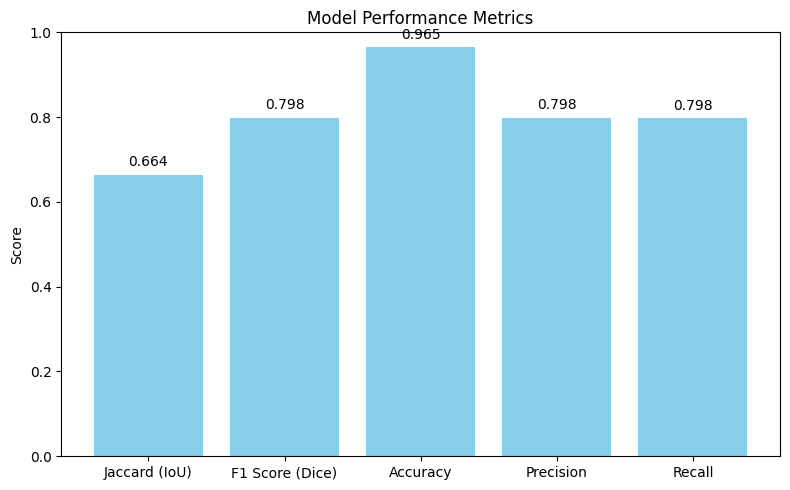

In [15]:
# =========================================
# Evaluation Metrics & Visualization
# =========================================
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

def evaluate_model(model, loader, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            preds = model(imgs)
            preds_bin = (preds > 0.5).cpu().numpy().astype(np.uint8)
            masks_np = masks.cpu().numpy().astype(np.uint8)

            # flatten to 1D for metric calculation
            for i in range(preds_bin.shape[0]):
                y_pred.append(preds_bin[i,0].flatten())
                y_true.append(masks_np[i,0].flatten())

    # concatenate all batches
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    metrics = {
        'Jaccard (IoU)': jaccard_score(y_true, y_pred),
        'F1 Score (Dice)': f1_score(y_true, y_pred),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred)
    }

    return metrics

def plot_metrics(metrics, save_path=None):
    plt.figure(figsize=(8,5))
    plt.bar(metrics.keys(), metrics.values(), color='skyblue')
    plt.ylim(0,1)
    for i, v in enumerate(metrics.values()):
        plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()


# =========================================
# Example Usage
# =========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model_path = '/content/drive/MyDrive/KaggleRetina/ode_unet_results/ode_unet_best.pth'

# Load the model
model = ODEUNet(in_channels=1, out_channels=1, base_ch=32, use_ode_at='bottleneck')
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state'])
model.to(device)

# Dataset and loader
test_ds = DriveDataset(val_img_dir, val_mask_dir)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False)

# Evaluate
metrics = evaluate_model(model, test_loader, device)
print("Evaluation Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# Plot metrics
plot_metrics(metrics, save_path='/content/drive/MyDrive/KaggleRetina/ode_unet_results/test_metrics.png')


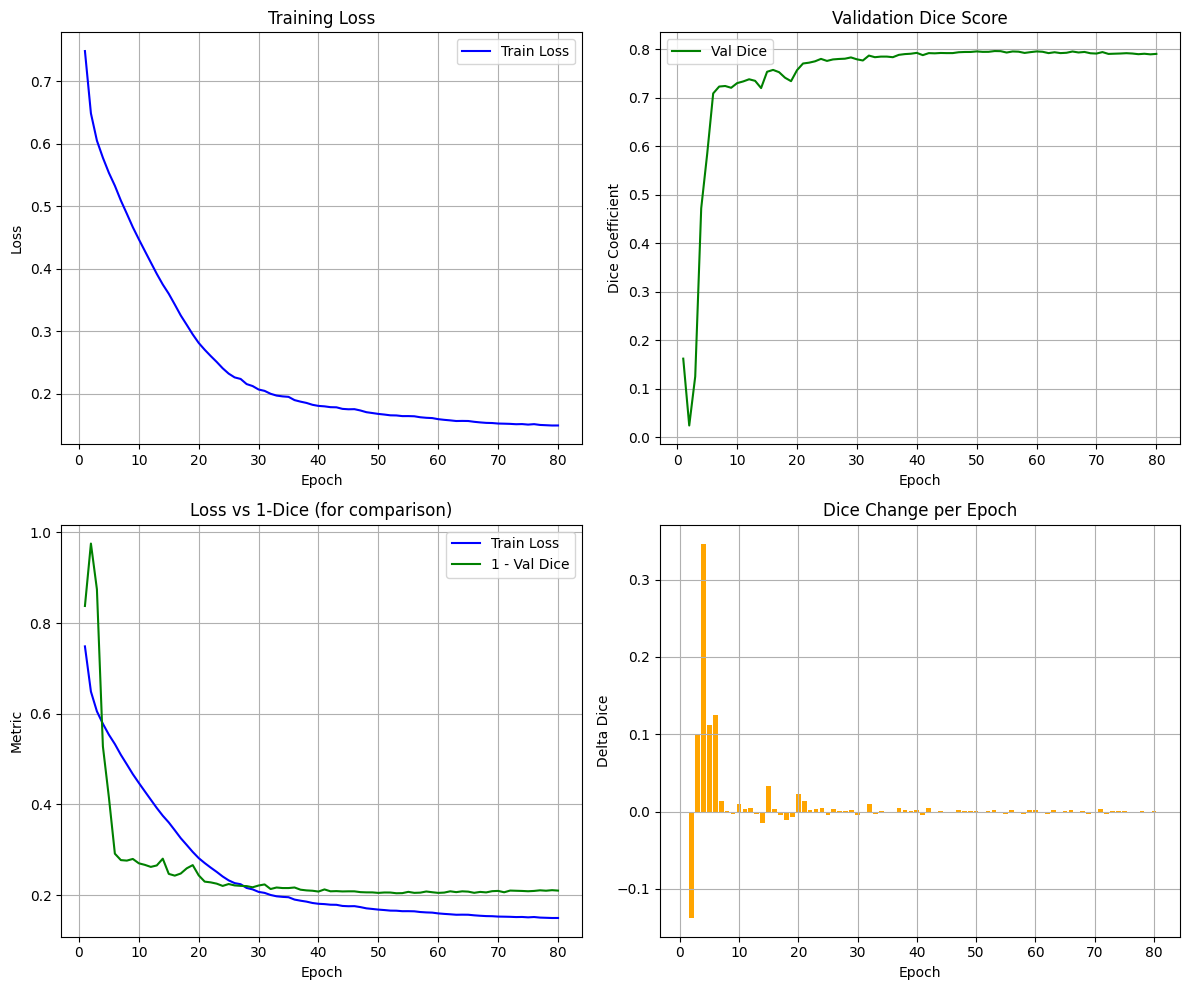

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# =========================================
# Visualize Training History
# =========================================
def plot_training_history(history, save_dir=None):
    """
    history: dict with keys 'train_loss' and 'val_dice'
    save_dir: optional directory to save plots
    """
    epochs = len(history['train_loss'])
    fig, axs = plt.subplots(2, 2, figsize=(12,10))

    # 1. Training Loss over epochs
    axs[0,0].plot(range(1, epochs+1), history['train_loss'], color='blue', label='Train Loss')
    axs[0,0].set_title('Training Loss')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Loss')
    axs[0,0].legend()
    axs[0,0].grid(True)

    # 2. Validation Dice over epochs
    axs[0,1].plot(range(1, epochs+1), history['val_dice'], color='green', label='Val Dice')
    axs[0,1].set_title('Validation Dice Score')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Dice Coefficient')
    axs[0,1].legend()
    axs[0,1].grid(True)

    # 3. Loss + Dice together
    axs[1,0].plot(range(1, epochs+1), history['train_loss'], color='blue', label='Train Loss')
    axs[1,0].plot(range(1, epochs+1), [1-d for d in history['val_dice']], color='green', label='1 - Val Dice')
    axs[1,0].set_title('Loss vs 1-Dice (for comparison)')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Metric')
    axs[1,0].legend()
    axs[1,0].grid(True)

    # 4. Dice improvement per epoch
    dice_diff = np.diff(history['val_dice'], prepend=history['val_dice'][0])
    axs[1,1].bar(range(1, epochs+1), dice_diff, color='orange')
    axs[1,1].set_title('Dice Change per Epoch')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Delta Dice')
    axs[1,1].grid(True)

    plt.tight_layout()

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, 'training_performance.png'))

    plt.show()


# =========================================
# Usage
# =========================================
plot_training_history(history, save_dir='/content/drive/MyDrive/KaggleRetina/ode_unet_results')

In [17]:
# =========================================
# Visualize Sample Predictions
# =========================================
def plot_sample_predictions(model, loader, device, n=4, save_dir=None):
    """
    model: trained model
    loader: DataLoader (validation or test)
    device: torch device
    n: number of samples to display
    save_dir: optional directory to save figure
    """
    import matplotlib.pyplot as plt
    import numpy as np

    model.eval()
    imgs_list, masks_list, preds_list = [], [], []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)
            preds = model(imgs)

            imgs_list.append(imgs.cpu())
            masks_list.append(masks.cpu())
            preds_list.append(preds.cpu())

            if sum(len(x) for x in imgs_list) >= n:
                break

    # Flatten batches
    imgs_all = torch.cat(imgs_list, dim=0)[:n]
    masks_all = torch.cat(masks_list, dim=0)[:n]
    preds_all = torch.cat(preds_list, dim=0)[:n]

    # Plot
    fig, axs = plt.subplots(n, 3, figsize=(12, 3*n))
    for i in range(n):
        # Input image (denormalize)
        inp_img = imgs_all[i,0]*0.5 + 0.5
        axs[i,0].imshow(inp_img, cmap='gray')
        axs[i,0].set_title('Input Image')
        axs[i,0].axis('off')

        # Ground truth mask
        axs[i,1].imshow(masks_all[i,0], cmap='gray')
        axs[i,1].set_title('Ground Truth')
        axs[i,1].axis('off')

        # Predicted mask
        axs[i,2].imshow((preds_all[i,0]>0.5).float(), cmap='gray')
        axs[i,2].set_title('Prediction')
        axs[i,2].axis('off')

    plt.tight_layout()

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, 'sample_predictions.png'))

    plt.show()


# =========================================
# Usage Example
# =========================================
val_ds = DriveDataset(val_img_dir, val_mask_dir)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

plot_sample_predictions(model, val_loader, device='cuda' if torch.cuda.is_available() else 'cpu',
                        n=20, save_dir='/content/drive/MyDrive/KaggleRetina/ode_unet_results')


Output hidden; open in https://colab.research.google.com to view.

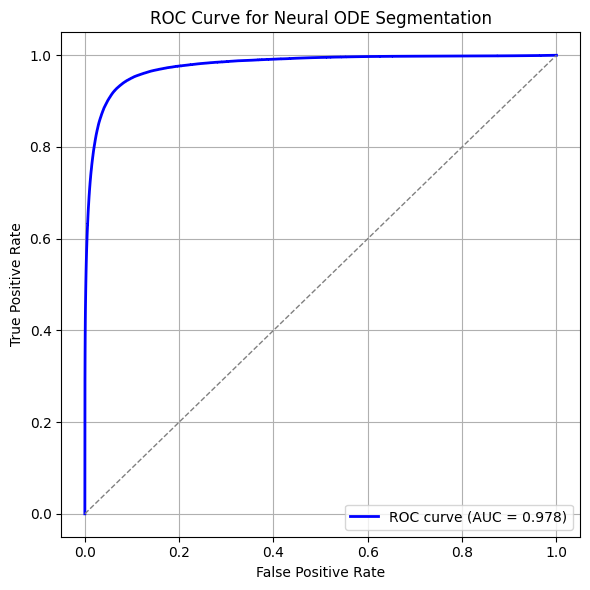

In [18]:
# =========================================
# ROC Curve for segmentation
# =========================================
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, loader, device, save_path=None):
    model.eval()
    y_true, y_prob = [], []

    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            preds = model(imgs)
            preds_np = preds.cpu().numpy().flatten()  # use probabilities
            masks_np = masks.cpu().numpy().flatten()

            y_prob.append(preds_np)
            y_true.append(masks_np)

    y_true = np.concatenate(y_true)
    y_prob = np.concatenate(y_prob)

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Neural ODE Segmentation')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

# =========================================
# Example usage
# =========================================
plot_roc_curve(model, test_loader, device, save_path='/content/drive/MyDrive/KaggleRetina/ode_unet_results/roc_curve.png')

In [21]:
# =========================================
# Individual Image Evaluation, Metrics & Visualization
# =========================================
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import os
import glob # Import glob function
import numpy as np # Import numpy

def evaluate_and_visualize_individual_images(model, loader, device, img_paths):
    model.eval()
    metrics_list = []

    with torch.no_grad():
        for idx, (imgs, masks) in enumerate(loader):
            imgs = imgs.to(device)
            masks = masks.to(device)

            preds = model(imgs)
            preds_bin = (preds > 0.5).cpu().numpy().astype(np.uint8)
            masks_np = masks.cpu().numpy().astype(np.uint8)
            imgs_np = imgs.cpu().numpy() # Get original image as numpy for display

            # Since batch size is 1, we can directly get the single image
            y_true = masks_np[0,0].flatten()
            y_pred = preds_bin[0,0].flatten()

            metrics = {
                'Jaccard (IoU)': jaccard_score(y_true, y_pred),
                'F1 Score (Dice)': f1_score(y_true, y_pred),
                'Accuracy': accuracy_score(y_true, y_pred),
                'Precision': precision_score(y_true, y_pred),
                'Recall': recall_score(y_true, y_pred)
            }
            metrics_list.append(metrics)

            # Print metrics for the current image
            image_name = os.path.basename(img_paths[idx])
            print(f"Metrics for Image: {image_name}")
            for k, v in metrics.items():
                print(f"  {k}: {v:.4f}")
            print("-" * 30)

            # --- Visualization for the current image ---
            fig, axs = plt.subplots(1, 3, figsize=(12, 4))

            # Input image (denormalize if normalized in dataset)
            # Assuming normalization (x - 0.5)/0.5 was applied
            inp_img = imgs_np[0,0]*0.5 + 0.5
            axs[0].imshow(inp_img, cmap='gray')
            axs[0].set_title('Input Image')
            axs[0].axis('off')

            # Ground truth mask
            axs[1].imshow(masks_np[0,0], cmap='gray')
            axs[1].set_title('Ground Truth')
            axs[1].axis('off')

            # Predicted mask
            axs[2].imshow(preds_bin[0,0], cmap='gray')
            axs[2].set_title('Prediction')
            axs[2].axis('off')

            plt.tight_layout()
            plt.show() # Display the plot immediately after metrics


    return metrics_list


# =========================================
# Example Usage for Individual Evaluation and Visualization
# =========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model_path = '/content/drive/MyDrive/KaggleRetina/ode_unet_results/ode_unet_best.pth'
val_img_dir = '/content/drive/MyDrive/KaggleRetina/test/image'
val_mask_dir = '/content/drive/MyDrive/KaggleRetina/test/mask'

# Load the model
model = ODEUNet(in_channels=1, out_channels=1, base_ch=32, use_ode_at='bottleneck')
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state'])
model.to(device)

# Dataset and loader with batch size 1 for individual evaluation and visualization
test_ds_individual = DriveDataset(val_img_dir, val_mask_dir)
test_loader_individual = DataLoader(test_ds_individual, batch_size=1, shuffle=False)

# Get image paths for printing names
test_img_paths = sorted(glob.glob(os.path.join(val_img_dir, '*.png'))) # Corrected glob usage

# Evaluate, visualize, and print metrics for individual images
individual_metrics_results = evaluate_and_visualize_individual_images(model, test_loader_individual, device, test_img_paths)

# You can optionally calculate and print the average metrics from the individual results
avg_metrics_from_individual = {}
if individual_metrics_results:
    for key in individual_metrics_results[0].keys():
        avg_metrics_from_individual[key] = np.mean([m[key] for m in individual_metrics_results])

    print("\nAverage Evaluation Metrics (from individual results):")
    for k, v in avg_metrics_from_individual.items():
        print(f"{k}: {v:.4f}")

Output hidden; open in https://colab.research.google.com to view.

In [34]:
# =========================================
# Imports
# =========================================
import torch
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
from torch.utils.data import DataLoader

# =========================================
# Vessel-Aware Post-processing Function
# =========================================
def enhance_vessel_mask(pred_mask):
    """
    Post-process the predicted mask to emphasize vessels, remove small noise,
    connect broken vessels, and slightly thicken valid vessels.
    """

    # Ensure uint8 binary format
    mask = (pred_mask * 255).astype(np.uint8)
    mask = cv2.medianBlur(mask, 3)  # smooth small salt/pepper noise

    # --- Step 1: Remove tiny speckles (below 5 pixels)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    min_area = 5
    cleaned_mask = np.zeros_like(mask)
    for i in range(1, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > min_area:
            cleaned_mask[labels == i] = 255

    # --- Step 2: Morphological closing to reconnect broken vessel lines
    closing_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    closed_mask = cv2.morphologyEx(cleaned_mask, cv2.MORPH_CLOSE, closing_kernel, iterations=1)

    # --- Step 3: Reduced dilation to thicken vessels slightly (half strength)
    dilation_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    dilated_mask = cv2.dilate(closed_mask, dilation_kernel, iterations=1)

    # --- Step 4: Skeleton re-enhancement to refine and keep vessels thin
    skeleton = cv2.ximgproc.thinning(dilated_mask, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
    # Blend less aggressively to avoid over-brightening
    blended = cv2.addWeighted(dilated_mask, 0.5, skeleton, 0.5, 0)

    # Final threshold
    processed_mask = (blended > 127).astype(np.uint8)
    return processed_mask


# =========================================
# Individual Image Evaluation + Visualization
# =========================================
def evaluate_and_visualize_individual_images(model, loader, device, img_paths):
    model.eval()
    metrics_list_before = []
    metrics_list_after = []

    save_dir = "/content/drive/MyDrive/KaggleRetina/results/postprocessing"
    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():
        for idx, (imgs, masks) in enumerate(loader):
            imgs = imgs.to(device)
            masks = masks.to(device)

            preds = model(imgs)
            preds_bin = (preds > 0.5).cpu().numpy().astype(np.uint8)[0, 0]
            masks_np = masks.cpu().numpy().astype(np.uint8)[0, 0]
            imgs_np = imgs.cpu().numpy()

            # --- Metrics (Before Post-processing)
            y_true_before = masks_np.flatten()
            y_pred_before = preds_bin.flatten()

            metrics_before = {
                'Jaccard (IoU)': jaccard_score(y_true_before, y_pred_before, zero_division=0),
                'F1 Score (Dice)': f1_score(y_true_before, y_pred_before, zero_division=0),
                'Accuracy': accuracy_score(y_true_before, y_pred_before),
                'Precision': precision_score(y_true_before, y_pred_before, zero_division=0),
                'Recall': recall_score(y_true_before, y_pred_before, zero_division=0)
            }
            metrics_list_before.append(metrics_before)

            # --- Post-processing ---
            preds_processed = enhance_vessel_mask(preds_bin)

            # --- Metrics (After Post-processing)
            y_true_after = masks_np.flatten()
            y_pred_after = preds_processed.flatten()

            metrics_after = {
                'Jaccard (IoU)': jaccard_score(y_true_after, y_pred_after, zero_division=0),
                'F1 Score (Dice)': f1_score(y_true_after, y_pred_after, zero_division=0),
                'Accuracy': accuracy_score(y_true_after, y_pred_after),
                'Precision': precision_score(y_true_after, y_pred_after, zero_division=0),
                'Recall': recall_score(y_true_after, y_pred_after, zero_division=0)
            }
            metrics_list_after.append(metrics_after)

            # --- Print metrics
            image_name = os.path.basename(img_paths[idx])
            print(f"\nMetrics for Image: {image_name}")
            print("  Before Post-processing:")
            for k, v in metrics_before.items():
                print(f"    {k}: {v:.4f}")
            print("  After Post-processing:")
            for k, v in metrics_after.items():
                print(f"    {k}: {v:.4f}")
            print("-" * 40)

            # --- Visualization ---
            fig, axs = plt.subplots(1, 4, figsize=(18, 4))

            inp_img = imgs_np[0, 0] * 0.5 + 0.5
            axs[0].imshow(inp_img, cmap='gray')
            axs[0].set_title('Input Image')
            axs[0].axis('off')

            axs[1].imshow(masks_np, cmap='gray')
            axs[1].set_title('Ground Truth')
            axs[1].axis('off')

            axs[2].imshow(preds_bin, cmap='gray')
            axs[2].set_title('Prediction (Original)')
            axs[2].axis('off')

            axs[3].imshow(preds_processed, cmap='gray')
            axs[3].set_title('Prediction (Processed)')
            axs[3].axis('off')

            plt.tight_layout()

            # Save BEFORE showing — this keeps the figure content intact
            save_path = os.path.join(save_dir, f"{image_name}_comparison.png")
            fig.savefig(save_path, bbox_inches='tight', dpi=200)
            plt.show()
            plt.close(fig)

    return metrics_list_before, metrics_list_after


# =========================================
# Example Usage for Individual Evaluation and Visualization
# =========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model_path = '/content/drive/MyDrive/KaggleRetina/ode_unet_results/ode_unet_best.pth'
val_img_dir = '/content/drive/MyDrive/KaggleRetina/test/image'
val_mask_dir = '/content/drive/MyDrive/KaggleRetina/test/mask'

# Load the model
model = ODEUNet(in_channels=1, out_channels=1, base_ch=32, use_ode_at='bottleneck')
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state'])
model.to(device)

# Dataset and loader
test_ds_individual = DriveDataset(val_img_dir, val_mask_dir)
test_loader_individual = DataLoader(test_ds_individual, batch_size=1, shuffle=False)

# Image paths
test_img_paths = sorted(glob.glob(os.path.join(val_img_dir, '*.png')))

# Evaluate, visualize, and print metrics
individual_metrics_results_before, individual_metrics_results_after = evaluate_and_visualize_individual_images(
    model, test_loader_individual, device, test_img_paths
)

# --- Average metrics
avg_metrics_from_individual_before = {}
if individual_metrics_results_before:
    for key in individual_metrics_results_before[0].keys():
        avg_metrics_from_individual_before[key] = np.mean([m[key] for m in individual_metrics_results_before])

    print("\nAverage Evaluation Metrics (Before Post-processing):")
    for k, v in avg_metrics_from_individual_before.items():
        print(f"{k}: {v:.4f}")

avg_metrics_from_individual_after = {}
if individual_metrics_results_after:
    for key in individual_metrics_results_after[0].keys():
        avg_metrics_from_individual_after[key] = np.mean([m[key] for m in individual_metrics_results_after])

    print("\nAverage Evaluation Metrics (After Post-processing):")
    for k, v in avg_metrics_from_individual_after.items():
        print(f"{k}: {v:.4f}")


Output hidden; open in https://colab.research.google.com to view.